<a href="https://colab.research.google.com/github/OliviaSifanWu/Machine-Learning-final-project/blob/main/ML_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
upload = files.upload()

Saving finaldata.csv to finaldata.csv


In [ ]:
data = pd.read_csv('finaldata.csv')
data

,UserID,ItemID,buy,cart,fav,pv,user_total_buy,user_total_cart,user_total_fav,user_total_pv,user_pv_conversion,user_cart_conversion,user_fav_conversion,item_total_buy,item_total_cart,item_total_fav,item_total_pv,item_pv_conversion,item_cart_conversion,item_fav_conversion
0,249,117060,0,0,0,1,2,11,0,135,0.014815,0.181818,0.0,0,0,0,1,0.0,0.0,0.0
1,249,154850,0,0,0,1,2,11,0,135,0.014815,0.181818,0.0,0,0,0,1,0.0,0.0,0.0
2,249,231053,0,0,0,1,2,11,0,135,0.014815,0.181818,0.0,0,0,0,6,0.0,0.0,0.0
3,249,484814,0,0,0,1,2,11,0,135,0.014815,0.181818,0.0,0,0,0,2,0.0,0.0,0.0
4,249,514776,0,0,0,1,2,11,0,135,0.014815,0.181818,0.0,0,0,0,7,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545788,1017956,4272510,0,0,0,1,0,1,1,17,0.000000,0.000000,0.0,0,0,0,2,0.0,0.0,0.0
545789,1017956,4450206,0,0,0,1,0,1,1,17,0.000000,0.000000,0.0,0,0,0,1,0.0,0.0,0.0
545790,1017956,4739866,0,0,0,1,0,1,1,17,0.000000,0.000000,0.0,0,0,0,1,0.0,0.0,0.0
545791,1017956,4833475,0,0,0,1,0,1,1,17,0.000000,0.000000,0.0,0,0,1,1,0.0,0.0,0.0


In [ ]:
# drop UserID and ItemID
data = data.drop(columns=['UserID','ItemID'])

In [ ]:
# split Xs and y
y = data[['buy']]
X = data.drop(columns=['buy'])

In [ ]:
# split nontest and test 
from sklearn.model_selection import train_test_split
X_nontest, X_test, y_nontest, y_test = train_test_split(X, y, test_size=0.7, random_state=123)

In [ ]:
X_nontest.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_nontest.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
pip install boruta

     |████████████████████████████████| 56 kB 1.4 MB/s 


In [ ]:
# scale data
# Standardized Xs

from numpy import absolute

columns = X_nontest.columns
to_scale_columns = []
for var in columns:
    if np.max(X_nontest[var])!=1:
        to_scale_columns.append(var)

nontest_to_sacle = X_nontest[to_scale_columns]
test_to_scale = X_test[to_scale_columns]




In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit to training set, apply to both trainig set and test set
scalerModel = scaler.fit(nontest_to_sacle)
nontest_scaled = scalerModel.transform(nontest_to_sacle)
test_scaled = scalerModel.transform(test_to_scale)

nontest_scaled = pd.DataFrame(nontest_scaled)
nontest_scaled.columns = to_scale_columns

test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = to_scale_columns

X_nontest_scaled = X_nontest.drop(columns=to_scale_columns)
X_nontest_scaled = X_nontest_scaled.join(nontest_scaled)

X_test_scaled = X_test.drop(columns=to_scale_columns)
X_test_scaled = X_test_scaled.join(test_scaled)

In [ ]:
# split nontest to train and feature selecting set 
X_train, X_sel, y_train, y_sel = train_test_split(X_nontest_scaled, y_nontest, test_size=0.2, random_state=123)

In [ ]:
# feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
ysel = y_sel.values.ravel()
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
trans = BorutaPy(clf, n_estimators=200, random_state=123, verbose=2)
sel = trans.fit(X_sel.values, ysel)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	0
I

In [ ]:
# check selected features
sel.support_


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False])

In [ ]:
# check ranking of features
sel.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2])

In [ ]:
# call transform() on X to filter it down to selected features
X_train_sel = sel.transform(X_train.values)
X_test_sel = sel.transform(X_test_scaled.values)

In [ ]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(X_train.columns, 
                         sel.ranking_, 
                         sel.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: cart                      Rank: 1,  Keep: True
Feature: fav                       Rank: 1,  Keep: True
Feature: pv                        Rank: 1,  Keep: True
Feature: user_total_buy            Rank: 1,  Keep: True
Feature: user_total_cart           Rank: 1,  Keep: True
Feature: user_total_fav            Rank: 1,  Keep: True
Feature: user_total_pv             Rank: 1,  Keep: True
Feature: user_pv_conversion        Rank: 1,  Keep: True
Feature: user_cart_conversion      Rank: 1,  Keep: True
Feature: user_fav_conversion       Rank: 1,  Keep: True
Feature: item_total_buy            Rank: 1,  Keep: True
Feature: item_total_cart           Rank: 1,  Keep: True
Feature: item_total_fav            Rank: 3,  Keep: False
Feature: item_total_pv             Rank: 1,  Keep: True
Feature: item_pv_conversion        Rank: 1,  Keep: True
Feature: item_cart_conversion      Rank: 1,  Keep: True
Feature: item_fav_conversion       Rank: 2,  Keep: False


In [ ]:

drop = []
for feat in feature_ranks:
  if feat[1] > 1:
    drop.append(feat[0]) 

# may run the following directly without running boruta again:
# drop = ['item_fav_conversion','item_total_fav'] 

X_TRAIN = X_train.drop(columns = drop )
X_TEST = X_test_scaled.drop(columns = drop )

In [ ]:
y_test = y_test.values.ravel()

In [ ]:
y_train = y_train.values.ravel()

In [ ]:
# Data after Scaling and feture selection: 
# X_TRAIN X_TEST y_train y_test
# Array like Xs: X_train_sel X_test_sel

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_TRAIN, y_train)
lr_predictions = lr.predict(X_TEST)

In [ ]:
# Model Evaluation
# Confusion matrix
from sklearn import metrics
lr_cm = metrics.confusion_matrix(y_test, lr_predictions)
print(lr_cm)

[[371727    611]
 [  9035    683]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    372338
           1       0.53      0.07      0.12      9718

    accuracy                           0.97    382056
   macro avg       0.75      0.53      0.56    382056
weighted avg       0.96      0.97      0.97    382056



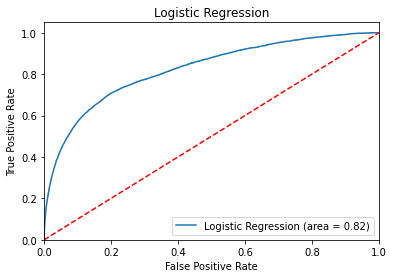

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr.predict_proba(X_TEST)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_TEST)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
# Data selection for svm
y_train_df = pd.DataFrame(y_train, columns=['y'])
TRAIN_data = pd.concat([X_TRAIN.reset_index(drop=True), y_train_df.reset_index(drop=True)], axis=1)
y_test_df = pd.DataFrame(y_test, columns=['y'])
TEST_data = pd.concat([X_TEST.reset_index(drop=True), y_test_df.reset_index(drop=True)], axis=1)

TRAIN_data_small = TRAIN_data.sample(n=30000)

In [ ]:
# SVM
from sklearn import svm

X_TRAIN_small = TRAIN_data_small.drop('y', axis=1)
y_train_small = TRAIN_data_small['y']

svc = svm.SVC(kernel='rbf', probability=True)
svc.fit(X_TRAIN_small, y_train_small)
svm_prediction = svc.predict(X_TEST)

In [ ]:
svm_cm = metrics.confusion_matrix(y_test, svm_prediction)
print(svm_cm)

[[372177    161]
 [  7758   1960]]


In [ ]:
print(classification_report(y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    372338
           1       0.92      0.20      0.33      9718

    accuracy                           0.98    382056
   macro avg       0.95      0.60      0.66    382056
weighted avg       0.98      0.98      0.97    382056



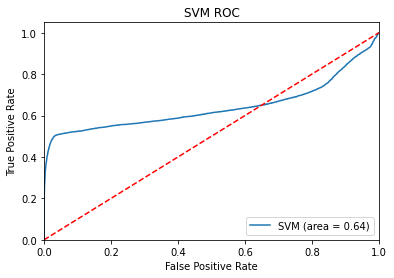

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(X_TEST)[:,1])
svm_roc_auc = roc_auc_score(y_test, svc.predict_proba(X_TEST)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

In [ ]:
# Imbalanced Classes
TRAIN_data_small['y'].value_counts()

0    29281
1      719
Name: y, dtype: int64

In [ ]:
from sklearn.utils import resample

In [ ]:
# Up-sampling
# Separate majority and minority classes
df_majority = TRAIN_data_small[TRAIN_data_small.y==0]
df_minority = TRAIN_data_small[TRAIN_data_small.y==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=29281,    # to match majority class
                                 random_state=1) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.y.value_counts()

0    29281
1    29281
Name: y, dtype: int64

In [ ]:
# Separate input features (X) and target variable (y)
y_up = df_upsampled.y
X_up = df_upsampled.drop('y', axis=1)
 
# Train model
svm_up = svc.fit(X_up, y_up)
 
# Predict on training set
pred_y_up = svm_up.predict_proba(X_TEST)

print( roc_auc_score(y_test, pred_y_up[:,1] ))



0.8791023418474562


In [ ]:
# Down-sampling
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=719,     # to match minority class
                                 random_state=1) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.y.value_counts()

0    719
1    719
Name: y, dtype: int64

In [ ]:
y_down = df_downsampled.y
X_down = df_downsampled.drop('y', axis=1)

svm_down = svc.fit(X_down, y_down)
pred_y_down = svm_down.predict_proba(X_TEST)
 
print('AUC: ')
print( roc_auc_score(y_test, pred_y_down[:,1] ))

AUC: 
0.8676249792847943


In [ ]:
# smote
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1)
X_smote, y_smote = sm.fit_resample(X_TRAIN_small, y_train_small)

In [ ]:
svm_smote = svc.fit(X_smote, y_smote)
pred_y_smote = svm_smote.predict_proba(X_TEST)
 
print('AUC: ')
print( roc_auc_score(y_test, pred_y_smote[:,1] ))

AUC: 
0.8718752024766225


In [ ]:
# up-sampling is optimal
# performance
svm_balanced_pred = svm_up.predict(X_TEST)
print(classification_report(y_test, svm_balanced_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93    372338
           1       0.13      0.72      0.22      9718

    accuracy                           0.87    382056
   macro avg       0.56      0.80      0.58    382056
weighted avg       0.97      0.87      0.91    382056



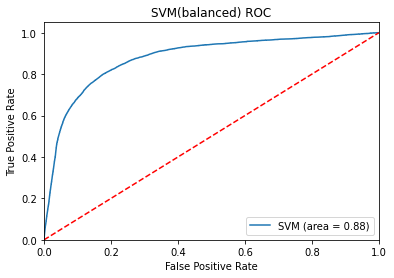

In [ ]:
# ROC
fpr, tpr, thresholds = roc_curve(y_test, pred_y_up[:,1])
svm_roc_auc = roc_auc_score(y_test, pred_y_up[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM(balanced) ROC')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

In [ ]:
# Neural network
!pip install h2o

     |████████████████████████████████| 176.2 MB 58 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.3-py2.py3-none-any.whl size=176244303 sha256=7e4ce20ac39ae71abd38ef0f5052be11118ae8c4149543af8310f771e5a4a2ed
  Stored in directory: /root/.cache/pip/wheels/b5/71/a5/02087a05e5644158183e1c58eeae3f9356a4d1e80659fb2dfb
Successfully built h2o


In [ ]:
import h2o
from h2o.estimators import H2ODeepLearningEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14" 2022-01-18; OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnciwn1y0
  JVM stdout: /tmp/tmpnciwn1y0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpnciwn1y0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_vtuves
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
h2o.shutdown()
h2o.init(nthreads=-1, max_mem_size="8G")

Checking whether there is an H2O instance running at http://localhost:54321 .

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


.... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14" 2022-01-18; OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv2h4qrr8
  JVM stdout: /tmp/tmpv2h4qrr8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpv2h4qrr8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_1099ug
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
TRAIN_data_nn = TRAIN_data.sample(n=5000)

In [ ]:
h2o_TRAIN_data = h2o.H2OFrame(TRAIN_data_nn)
h2o_TEST_data = h2o.H2OFrame(TEST_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Build and train the model
# Tuning with grid search
params = {
    'hidden': [[32,32,],[32,16,8]],
    'activation': ["Tanh", "TanhWithDropout", "Rectifier", "RectifierWithDropout"],
    'input_dropout_ratio': [0.0, 0.05],
    'l1': [0, 1e-5, 1e-3],
    'l2': [0, 1e-5, 1e-3],
    'max_w2': [5,10]
    }

grid_search_nn = H2ODeepLearningEstimator(
    distribution="multinomial",
    train_samples_per_iteration=-1,
    stopping_metric="MSE",
    stopping_tolerance=1e-2,
    stopping_rounds=2,
    seed=0,
    score_duty_cycle=0.025,

)

#from sklearn.model_selection import GridSearchCV
from h2o.grid.grid_search import H2OGridSearch


nn_grid = H2OGridSearch(grid_search_nn, params,
                         grid_id='nn_grid')

h2o_TRAIN_data['y']=h2o_TRAIN_data['y'].asfactor()

# Identify predictors and response
x = h2o_TRAIN_data.columns
y = "y"
x.remove(y)

# Split data into train & validation
ss = h2o_TRAIN_data.split_frame(seed = 0)
train = ss[0]
valid = ss[1]

#Train grid search
nn_grid.train(x=x, y=y,
                training_frame=train,
                epochs=10,
                validation_frame=valid,
                seed=0)


deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
             activation       hidden  input_dropout_ratio       l1       l2  \
0             Rectifier  [32, 16, 8]                 0.05  0.00001  0.00001   
1             Rectifier     [32, 32]                 0.00  0.00100  0.00001   
2             Rectifier  [32, 16, 8]                 0.00  0.00000  0.00100   
3             Rectifier     [32, 32]                 0.00  0.00100  0.00100   
4             Rectifier     [32, 32]                 0.05  0.00100  0.00000   
..  ..              ...          ...                  ...      ...      ...   
283     TanhWithDropout  [32, 16, 8]                 0.00  0.00000  0.00001   
284     TanhWithDropout  [32, 16, 8]                 0.05  0.00001  0.00001   
285     TanhWithDropout  [32, 16, 8]                 0.00  0.00001  0.00000   
286     TanhWithDropout  [32, 16, 8]                 0.05  0.00001  0.00000   
287     TanhWithDropout  [32, 16, 8]

In [ ]:
# Get the grid results, sorted by validation AUC
nn_gridperf = nn_grid.get_grid(sort_by='AUC', decreasing=True)
nn_gridperf

# Grab the top NN model, chosen by validation AUC
best_nn = nn_gridperf.models[0]

In [ ]:
best_nn.model_performance(h2o_TEST_data)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.022445490745949887
RMSE: 0.14981819230637475
LogLoss: 0.0952465849987776
Mean Per-Class Error: 0.36796901411935573
AUC: 0.8535903944981373
AUCPR: 0.22117040482331024
Gini: 0.7071807889962747

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14069423682439805: 


,,0,1,Error,Rate
0,0,364796.0,7542.0,0.0203,(7542.0/372338.0)
1,1,6955.0,2763.0,0.7157,(6955.0/9718.0)
2,Total,371751.0,10305.0,0.0379,(14497.0/382056.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.140694,0.275983,209.0
1,max f2,0.053148,0.356109,282.0
2,max f0point5,0.325673,0.314848,134.0
3,max accuracy,0.862258,0.975019,25.0
4,max precision,0.999405,0.743802,0.0
5,max recall,0.000775,1.000000,399.0
6,max specificity,0.999405,0.999917,0.0
7,max absolute_mcc,0.078621,0.257073,256.0
8,max min_per_class_accuracy,0.018987,0.783186,334.0
9,max mean_per_class_accuracy,0.016757,0.786625,339.0



Gains/Lift Table: Avg response rate:  2.54 %, avg score:  2.42 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,3.110627e-01,16.164016,16.164016,0.411149,0.580995,0.411149,0.580995,0.161659,0.161659,1516.401620,1516.401620,0.155616
1,2,0.020013,1.768835e-01,7.893687,12.026688,0.200784,0.231472,0.305912,0.406142,0.079029,0.240687,689.368715,1102.668837,0.226434
2,3,0.030035,1.283571e-01,5.903813,9.983596,0.150170,0.149727,0.253943,0.320581,0.059169,0.299856,490.381320,898.359565,0.276863
3,4,0.040002,1.034850e-01,4.800717,8.692200,0.122111,0.114856,0.221095,0.269321,0.047849,0.347705,380.071742,769.219996,0.315734
4,5,0.050008,8.563173e-02,4.514507,7.856268,0.114831,0.093957,0.199833,0.234232,0.045174,0.392879,351.450722,685.626782,0.351820
5,6,0.100046,4.616878e-02,3.335656,5.595311,0.084846,0.061919,0.142323,0.148051,0.166907,0.559786,233.565587,459.531137,0.471740
6,7,0.150015,3.081781e-02,1.933691,4.375644,0.049185,0.037563,0.111299,0.111248,0.096625,0.656411,93.369086,337.564432,0.519613
7,8,0.200034,2.210936e-02,1.728099,3.713620,0.043956,0.026156,0.094460,0.089970,0.086438,0.742848,72.809944,271.361953,0.556982
8,9,0.300001,1.324772e-02,1.100383,2.842830,0.027989,0.016966,0.072310,0.065644,0.110002,0.852850,10.038348,184.282964,0.567279
9,10,0.400030,9.725086e-03,0.473207,2.250292,0.012037,0.011101,0.057239,0.052005,0.047335,0.900185,-52.679277,125.029225,0.513209


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


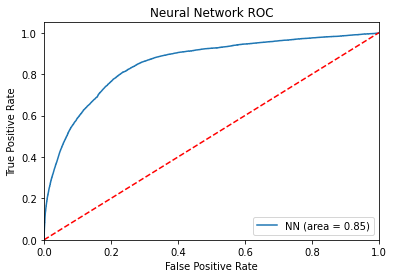

In [ ]:
h2o_X_TEST = h2o_TEST_data.drop('y')
nn_pred = best_nn.predict(h2o_X_TEST)
nn_pred_array = nn_pred[:,2].as_data_frame().to_numpy()

fpr, tpr, thresholds = roc_curve(y_test, nn_pred_array)
nn_roc_auc = roc_auc_score(y_test, nn_pred_array)
plt.figure()
plt.plot(fpr, tpr, label='NN (area = %0.2f)' % nn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
nn_pred_array

array([[0.00460626],
       [0.03077317],
       [0.00582959],
       ...,
       [0.00994377],
       [0.01540935],
       [0.00346689]])

In [ ]:
y_train_df = pd.DataFrame(y_train, columns=['y'])
TRAIN_data = pd.concat([X_TRAIN, y_train_df], axis=1).reindex(X_TRAIN.index)
TRAIN_data

,cart,fav,pv,user_total_buy,user_total_cart,user_total_fav,user_total_pv,user_pv_conversion,user_cart_conversion,user_fav_conversion,item_total_buy,item_total_cart,item_total_pv,item_pv_conversion,item_cart_conversion,y
73013,0.0,0.0,-0.191665,-0.603966,-0.725273,-0.443518,-1.288413,-0.231784,-0.355584,-0.280873,-0.106326,-0.363491,-0.393501,-0.075866,-0.083277,0.0
24292,0.0,0.0,-0.191665,-0.241732,-0.403230,0.047285,-0.780900,-0.000155,-0.084197,-0.094772,-0.106326,-0.363491,-0.393501,-0.075866,-0.083277,0.0
100305,0.0,0.0,-0.191665,-0.603966,-0.725273,3.188425,-0.392802,-0.231784,-0.355584,-0.280873,-0.106326,-0.363491,0.083219,-0.075866,-0.083277,1.0
108516,0.0,0.0,-0.191665,-0.603966,-0.725273,-0.443518,-0.751046,-0.231784,-0.355584,-0.280873,-0.106326,-0.363491,-0.393501,-0.075866,-0.083277,0.0
8364,0.0,0.0,-0.191665,-0.603966,-0.725273,-0.443518,-1.119242,-0.231784,-0.355584,-0.280873,-0.106326,-0.363491,-0.075687,-0.075866,-0.083277,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146449,0.0,0.0,-0.191665,-0.603966,-0.832620,-0.443518,-0.044509,-0.231784,-0.355584,-0.280873,-0.106326,0.673407,1.195567,-0.075866,-0.083277,NaN
119906,0.0,0.0,-0.191665,3.018371,0.026160,-0.247197,1.607394,0.255857,1.001352,4.371650,-0.106326,1.710304,0.798300,-0.075866,-0.083277,0.0
17730,0.0,0.0,-0.191665,0.482735,0.992288,-0.345357,-0.263436,0.151602,-0.164016,2.510641,-0.106326,1.710304,0.401033,-0.075866,-0.083277,0.0
28030,0.0,1.0,-0.191665,-0.603966,0.240855,3.188425,1.487980,-0.231784,-0.355584,-0.280873,-0.106326,-0.363491,0.162673,-0.075866,-0.083277,0.0


In [ ]:
y_train_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
130984,0
130985,0
130986,0
130987,0


In [ ]:
# Tuning for Decision Tree
from sklearn import tree
dt = tree.DecisionTreeClassifier()
test_params = {'max_depth':[4,8,12], 'splitter':['best', 'random'], 'criterion':['gini', 'entropy']}
model_dt = GridSearchCV(estimator=dt, param_grid=test_params)
model_dt.fit(X_TRAIN, y_train)
print(model_dt.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}


In [ ]:
# Decision Tree with the best parameters
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8, splitter='best')
dt.fit(X_TRAIN, y_train)
dt_predictions = dt.predict(X_TEST)

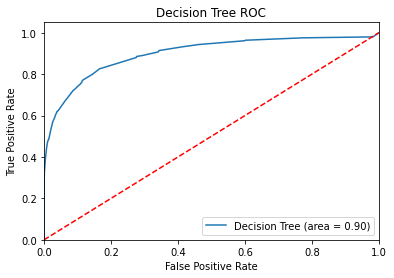

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    372338
           1       0.84      0.34      0.49      9718

    accuracy                           0.98    382056
   macro avg       0.91      0.67      0.74    382056
weighted avg       0.98      0.98      0.98    382056

[[371692    646]
 [  6396   3322]]


In [ ]:
# Decision Tree ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, dt.predict_proba(X_TEST)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, dt.predict_proba(X_TEST)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, dt_predictions))

dt_cm = metrics.confusion_matrix(y_test, dt_predictions)
print(dt_cm)

In [ ]:
# Tuning for Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
test_params = {'max_depth':[4,8,12], 'criterion':['gini', 'entropy']}
model_rf = GridSearchCV(estimator=rf, param_grid=test_params)
model_rf.fit(X_TRAIN, y_train)
print(model_rf.best_params_)

{'criterion': 'entropy', 'max_depth': 12}


In [ ]:
# Random Forest with the best parameters
rf = RandomForestClassifier(criterion='entropy', max_depth=12)
rf.fit(X_TRAIN, y_train)
rf_predictions = rf.predict(X_TEST)

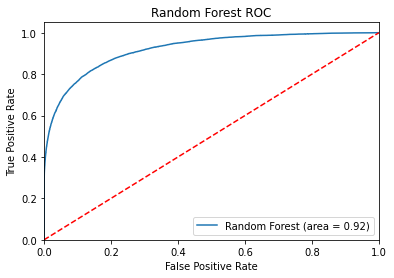

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    372338
           1       0.92      0.32      0.48      9718

    accuracy                           0.98    382056
   macro avg       0.95      0.66      0.73    382056
weighted avg       0.98      0.98      0.98    382056

[[372073    265]
 [  6574   3144]]


In [ ]:
# Random Forest ROC
logit_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_TEST)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_TEST)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, rf_predictions))
from sklearn import metrics
rf_cm = metrics.confusion_matrix(y_test, rf_predictions)
print(rf_cm)

In [ ]:
# Tuning for XGBoost
# A parameter grid for XGBoost
import xgboost as xgb

params = {
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'min_child_weight': [10, 20, 30, 40, 50],
        'gamma': [1, 2, 5],
        'subsample': [0.5, 0.65, 0.8],
        'max_depth': [1, 3, 5, 8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        }

xgb = xgb.XGBClassifier(n_estimators=400,
                   silent=True, 
                   early_stopping_rounds=10, 
                   nthread=1)


folds = 5
param_comb = 300

kf = KFold(n_splits=folds, shuffle=True)

In [ ]:
#Random Search
random_search = RandomizedSearchCV(xgb, param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='roc_auc', n_jobs=4, 
                                   cv=kf.split(X_TRAIN, y_train), 
                                   verbose=3, 
                                   )

random_search.fit(X_TRAIN, y_train)

#print('\n All results:')
#print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
print('\n Best score:')
print(random_search.best_score_)
result = pd.DataFrame(random_search.cv_results_)
result.to_csv('xgb-random-grid-search-results-01.csv', index=False)

best_pram=random_search.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [ ]:
# XGBoost with the best parameters
xgb_best = XGBClassifier(subsample=best_pram['subsample'], 
                     min_child_weight=best_pram['min_child_weight'], 
                     max_depth=best_pram['max_depth'], 
                     gamma=best_pram['gamma'], 
                     learning_rate=best_pram['learning_rate'], 
                     colsample_bytree=best_pram['colsample_bytree'], 
                     n_estimators=1000,
                     nthread=1)

xgb_best.fit(X_TRAIN, y_train)

In [ ]:
# XGBoost ROC
XGB_roc_auc = roc_auc_score(y_test, xgb_best.predict_proba(X_TEST)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, xgb_best.predict_proba(X_TEST)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Boosting (area = %0.2f)' % XGB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Boosting')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

y_pred_XGBoost = xgb_best.predict(X_TEST)

from sklearn.metrics import classification_report
from sklearn import metrics
print(classification_report(y_test, y_pred_XGBoost))

xgboost_cm = metrics.confusion_matrix(y_test, y_pred_XGBoost)
print(xgboost_cm)

In [ ]:
# XGBoost
import xgboost as xgb

XGBoost = xgb.XGBClassifier().fit(X_TRAIN, y_train)
y_pred_XGBoost = XGBoost.predict(X_TEST)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


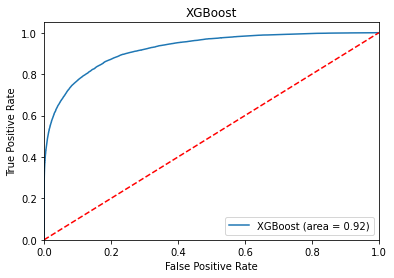

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    372338
           1       0.91      0.32      0.47      9718

    accuracy                           0.98    382056
   macro avg       0.95      0.66      0.73    382056
weighted avg       0.98      0.98      0.98    382056

[[372022    316]
 [  6612   3106]]


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, XGBoost.predict_proba(X_TEST)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, XGBoost.predict_proba(X_TEST)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_XGBoost))

xgboost_cm = metrics.confusion_matrix(y_test, y_pred_XGBoost)
print(xgboost_cm)

In [ ]:
# Grid search the best XGBoost
best_auc = 0

for :
  XGBoost = xgb.XGBClassifier().fit(X_TRAIN, y_train)
  y_pred_XGBoost = XGBoost.predict(X_TEST)
  logit_roc_auc = roc_auc_score(y_test, XGBoost.predict_proba(X_TEST)[:, 1])


In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 

xgb_model = XGBClassifier()

test_params = {
 'max_depth':[4,8,12]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(X_TRAIN,y_train)
print(model.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

{'max_depth': 4}
